In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

# To list all indices, do 
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/_settings?pretty=1' 
ind="jobs_archive_2016-04*"

# one can also use the following command to see the return json data.
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/jobs_archive_2016*/_search?pretty=1&size=1'

x = {
    "fields": ["wall_time","modificationtime","modificationhost","cpu_eff","corecount"],
    "query": {
        "bool": {
            "must": [{ "match": { "computingsite": "SLACXRD_MP8" }},
                     { "match": { "jobstatus": "finished" }}] 
        }
    }
}

# kiso, deft-239-1* deft-239-2*, deft-v*
walltimes = [[], [], [], [], [], []]
waittimes = [[], [], [], [], [], []]
cpu_effs = [[], [], [], [], [], []]
# period the NAT was set on the fells:
timerange0 = datetime.strptime("2016-04-12","%Y-%m-%d")
timerange1 = datetime.strptime("2016-04-30","%Y-%m-%d")

page = es.search(index=ind, body=x, search_type="scan", scroll="1m")
scroll_size = page['hits']['total']

while (scroll_size > 0):
    try:
        sid = page['_scroll_id']
        page = es.scroll(scroll_id = sid, scroll = '1m')
        scroll_size = len(page['hits']['hits'])
        for job in page['hits']['hits']:
            #print(job)
            timestamp = datetime.strptime(job['fields']['modificationtime'][0],"%Y-%m-%dT%H:%M:%S")
            if (timestamp<timerange0 or timestamp>timerange1):
                continue                               
            wallt = job['fields']['wall_time'][0]/60
            cpu_eff = job['fields']['cpu_eff'][0]
            corecount = job['fields']['corecount'][0]
            waitt = wallt - cpu_eff * wallt / corecount
            #print ("hostname: %s, walltime: %.2f" % (hostn, wallt))
            if (wallt<5 or wallt>2005):
                continue

            hostname = job['fields']['modificationhost'][0]
            if re.search("kiso",hostname) is not None:
                walltimes[0] += [wallt]
                waittimes[0] += [waitt]
                cpu_effs[0] += [cpu_eff]
            elif re.search("deft-239-1",hostname) is not None:
                walltimes[1] += [wallt]
                waittimes[1] += [waitt]
                cpu_effs[1] += [cpu_eff]
            elif re.search("deft-239-2",hostname) is not None:
                walltimes[2] += [wallt]
                waittimes[2] += [waitt]
                cpu_effs[2] += [cpu_eff]
            elif re.search("deft-v",hostname) is not None:
                walltimes[3] += [wallt]
                waittimes[3] += [waitt]
                cpu_effs[3] += [cpu_eff]
            elif re.search("deft0001",hostname) is not None:
                walltimes[4] += [wallt]
                waittimes[4] += [waitt]
                cpu_effs[4] += [cpu_eff]
            elif re.search("bullet",hostname) is not None:
                walltimes[5] += [wallt]
                waittimes[5] += [waitt]
                cpu_effs[5] += [cpu_eff]
    except:
        continue

print("%d %d %d %d %d %d" % (len(walltimes[0]), len(walltimes[1]), len(walltimes[2]), len(walltimes[3]),
                             len(walltimes[4]), len(walltimes[5]) ))

4684 1577 2027 152 224 14138


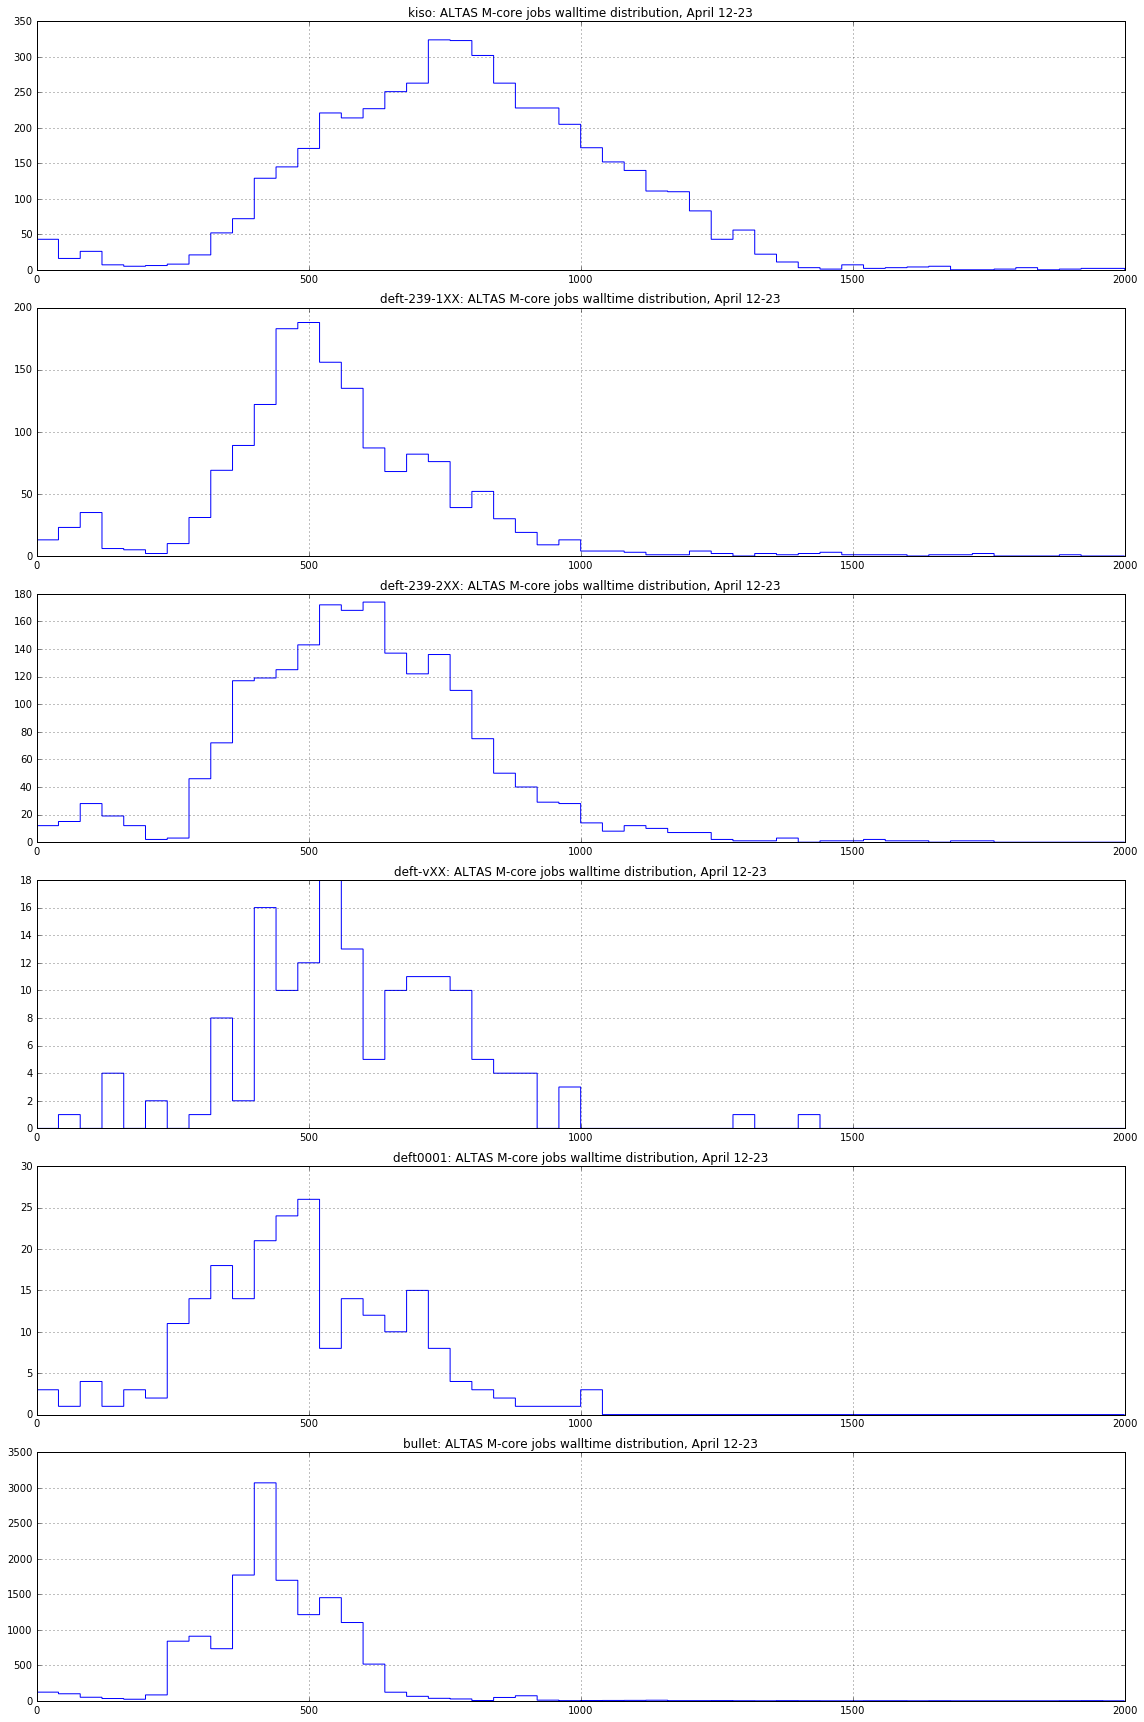

In [2]:
#fig, ax0 = plt.subplots(figsize=(16, 8))
#n, bins, patches = ax.hist(walltimes, 50, histtype='step', normed=1, color=['y','b','g','r'], 
#                           label=["kiso","deft-239-1","deft-239-2","deft-v"])
#ax.set_title('mp4 walltimes')

#fig = plt.figure(figsize=(10,10))
#ax0 = fig.add_axes([.1, .55, .9, .9])
#ax1 = fig.add_axes([.1, .1, .45, .45])
#ax2 = fig.add_axes([.55, .1, .9, .45])

colors=['y','b','g','r','o', 'b']
labels=["kiso","deft-239-1XX","deft-239-2XX","deft-vXX","deft0001","bullet"]

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(16,24))
ax0.hist(walltimes[0], bins=50, range=[0,2000], histtype='step')
ax0.set_title("kiso: ALTAS M-core jobs walltime distribution, April 12-23")
ax0.grid(True)

ax1.hist(walltimes[1], bins=50, range=[0,2000], histtype='step')
ax1.set_title("deft-239-1XX: ALTAS M-core jobs walltime distribution, April 12-23")
ax1.grid(True)

ax2.hist(walltimes[2], bins=50, range=[0,2000], histtype='step')
ax2.set_title("deft-239-2XX: ALTAS M-core jobs walltime distribution, April 12-23")
ax2.grid(True)

ax3.hist(walltimes[3], bins=50, range=[0,2000], histtype='step')
ax3.set_title("deft-vXX: ALTAS M-core jobs walltime distribution, April 12-23")
ax3.grid(True)

ax4.hist(walltimes[4], bins=50, range=[0,2000], histtype='step')
ax4.set_title("deft0001: ALTAS M-core jobs walltime distribution, April 12-23")
ax4.grid(True)

ax5.hist(walltimes[5], bins=50, range=[0,2000], histtype='step')
ax5.set_title("bullet: ALTAS M-core jobs walltime distribution, April 12-23")
ax5.grid(True)

#fig, ax0 = plt.subplots(figsize=(15,15))
#ax0.hist(walltimes, 50, histtype='step', normed=1, label=lables)
#ax0.set_title("ALTAS M-core jobs walltime distribution, April 12-23")
#ax1.hist(waittimes, 50, histtype='step', normed=1, label=labels)
#ax2.hist(cpu_effs,  50, histtype='step', normed=1, label=labels)
#ax2.set_title("cputime / walltime")
#fig.canvas.draw()
#plt.legend()
plt.tight_layout()
plt.show()

#fig.savefig("mp4jobs.png")